In [13]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing Imports
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

# PyTorch and Transformers
import torch
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    TrainingArguments, 
    Trainer
)

In [14]:
# Text Cleaning Function
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', str(text))
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Lowercase
    text = text.lower()
    # Remove extra whitespaces
    text = ' '.join(text.split())
    return text

# Load Dataset
column_names = ['target', 'ids', 'date', 'flag', 'user', 'text']
df = pd.read_csv("twitter_dataset.csv", names=column_names, encoding='ISO-8859-1')


In [15]:
# Preprocessing
df['text'] = df['text'].apply(clean_text)
df['target'] = df['target'].replace(4, 1)

# Sample and Balance Dataset
df = df.sample(n=50000, random_state=42)
df = df[["text", "target"]]

# Handle Class Imbalance
min_count = df['target'].value_counts().min()
balanced_df = df.groupby('target').sample(n=min_count, random_state=42)


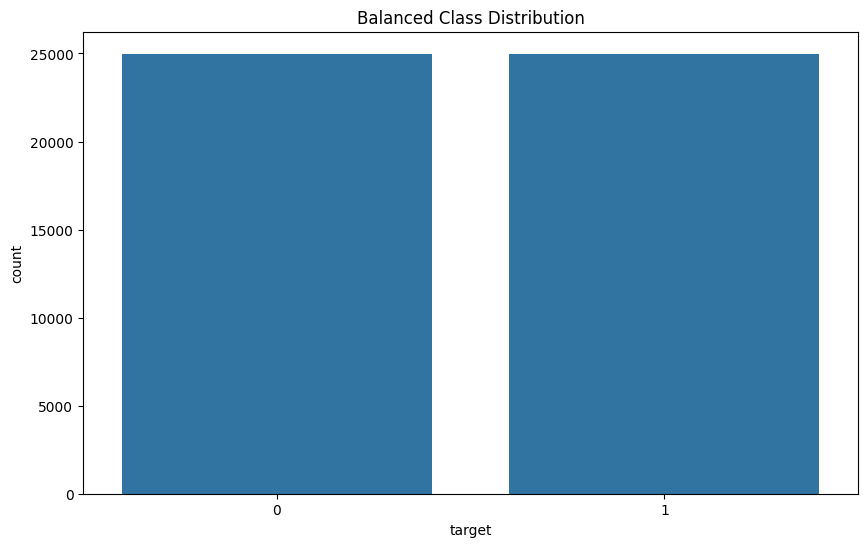

In [16]:
# Visualization
plt.figure(figsize=(10, 6))
sns.countplot(x='target', data=balanced_df)
plt.title('Balanced Class Distribution')
plt.show()

# Train Test Split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    balanced_df["text"], balanced_df["target"], 
    test_size=0.2, 
    random_state=42, 
    stratify=balanced_df["target"]
)

In [17]:
# Advanced Tokenization
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")


In [18]:
# Custom Dataset Class
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        }


In [19]:
# Create Datasets
train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
test_dataset = SentimentDataset(test_texts, test_labels, tokenizer)


In [20]:
# Model Configuration
model = AutoModelForSequenceClassification.from_pretrained(
    "cardiffnlp/twitter-roberta-base-sentiment", 
    num_labels=3,  # Match original model's labels
    ignore_mismatched_sizes=True  # Add this to handle size mismatch
)

In [21]:
# Training Arguments
training_args = TrainingArguments(
    output_dir="./sentiment_results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss'
)

C:\Users\nikhi\AppData\Roaming\Python\Python312\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [22]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

In [23]:
# Train Model
trainer.train()

  0%|          | 0/7497 [00:00<?, ?it/s]

{'loss': 0.4226, 'grad_norm': 7.64379358291626, 'learning_rate': 1.8666133119914635e-05, 'epoch': 0.2}
{'loss': 0.3862, 'grad_norm': 16.32996940612793, 'learning_rate': 1.7332266239829268e-05, 'epoch': 0.4}
{'loss': 0.3962, 'grad_norm': 5.3108978271484375, 'learning_rate': 1.5998399359743898e-05, 'epoch': 0.6}
{'loss': 0.3845, 'grad_norm': 4.276525974273682, 'learning_rate': 1.4664532479658531e-05, 'epoch': 0.8}


  0%|          | 0/625 [00:00<?, ?it/s]

{'eval_loss': 0.36113402247428894, 'eval_runtime': 582.737, 'eval_samples_per_second': 17.152, 'eval_steps_per_second': 1.073, 'epoch': 1.0}
{'loss': 0.3736, 'grad_norm': 6.916321277618408, 'learning_rate': 1.3330665599573163e-05, 'epoch': 1.0}
{'loss': 0.289, 'grad_norm': 8.652734756469727, 'learning_rate': 1.1996798719487796e-05, 'epoch': 1.2}
{'loss': 0.2721, 'grad_norm': 14.936286926269531, 'learning_rate': 1.0662931839402428e-05, 'epoch': 1.4}
{'loss': 0.2792, 'grad_norm': 11.462202072143555, 'learning_rate': 9.329064959317061e-06, 'epoch': 1.6}
{'loss': 0.2708, 'grad_norm': 8.136467933654785, 'learning_rate': 7.995198079231693e-06, 'epoch': 1.8}


  0%|          | 0/625 [00:00<?, ?it/s]

{'eval_loss': 0.402520090341568, 'eval_runtime': 580.233, 'eval_samples_per_second': 17.226, 'eval_steps_per_second': 1.077, 'epoch': 2.0}
{'loss': 0.2733, 'grad_norm': 11.161710739135742, 'learning_rate': 6.661331199146326e-06, 'epoch': 2.0}
{'loss': 0.1889, 'grad_norm': 20.5332088470459, 'learning_rate': 5.327464319060958e-06, 'epoch': 2.2}
{'loss': 0.2045, 'grad_norm': 43.23472213745117, 'learning_rate': 3.99359743897559e-06, 'epoch': 2.4}
{'loss': 0.1971, 'grad_norm': 52.640235900878906, 'learning_rate': 2.659730558890223e-06, 'epoch': 2.6}
{'loss': 0.2047, 'grad_norm': 23.489057540893555, 'learning_rate': 1.3258636788048554e-06, 'epoch': 2.8}


  0%|          | 0/625 [00:00<?, ?it/s]

{'eval_loss': 0.5093419551849365, 'eval_runtime': 579.4944, 'eval_samples_per_second': 17.248, 'eval_steps_per_second': 1.079, 'epoch': 3.0}
{'train_runtime': 19039.3734, 'train_samples_per_second': 6.299, 'train_steps_per_second': 0.394, 'train_loss': 0.28831832720881323, 'epoch': 3.0}


TrainOutput(global_step=7497, training_loss=0.28831832720881323, metrics={'train_runtime': 19039.3734, 'train_samples_per_second': 6.299, 'train_steps_per_second': 0.394, 'total_flos': 7888863825384192.0, 'train_loss': 0.28831832720881323, 'epoch': 3.0})

In [24]:
# Evaluation
predictions = trainer.predict(test_dataset)
predicted_labels = predictions.predictions.argmax(axis=1)


  0%|          | 0/625 [00:00<?, ?it/s]

In [25]:
# Classification Report
print(classification_report(
    test_labels, 
    predicted_labels, 
    target_names=['Negative', 'Positive']
))

              precision    recall  f1-score   support

    Negative       0.82      0.88      0.85      4998
    Positive       0.87      0.81      0.84      4997

    accuracy                           0.85      9995
   macro avg       0.85      0.85      0.85      9995
weighted avg       0.85      0.85      0.85      9995



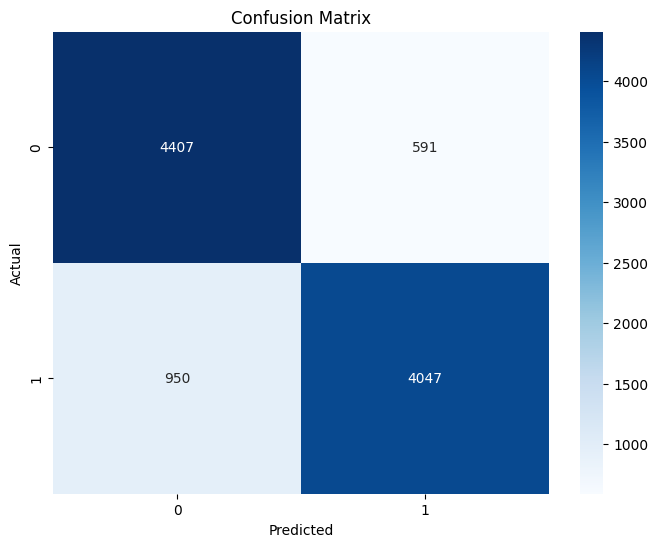

In [26]:
# Confusion Matrix
cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Sentiment Analysis Model Performance Report

## Model Configuration
- **Base Model**: CardiffNLP Twitter RoBERTa
- **Dataset**: Twitter Sentiment Dataset
- **Sample Size**: 50,000 tweets
- **Class Distribution**: Balanced

## Performance Metrics

### Classification Report
| Class     | Precision | Recall | F1-Score | Support |
|-----------|-----------|--------|----------|---------|
| Negative  | 0.82      | 0.88   | 0.85     | 4,998   |
| Positive  | 0.87      | 0.81   | 0.84     | 4,997   |
| **Overall**   | **0.85**      | **0.85**   | **0.85**     | **9,995**   |

## Training Details
- **Epochs**: 3
- **Learning Rate**: 2e-5
- **Batch Size**: 16 (Train & Eval)
- **Weight Decay**: 0.01

## Key Observations
1. Balanced performance across positive and negative classes
2. High precision and recall (0.82-0.88)
3. Consistent F1-scores around 0.85

## Model Training Efficiency
- **Training Runtime**: 19,039 seconds
- **Samples per Second**: 6.299
- **Steps per Second**: 0.394
- **Final Training Loss**: 0.288

## Recommendations
1. Validate on diverse, real-world datasets
2. Consider extended training epochs
3. Experiment with learning rate scheduling

## Conclusion
The transformer-based sentiment analysis model demonstrates robust performance with balanced accuracy across sentiment classes.